In this notebook I applied Bayesian Neural Network(BNN) to mnist problem.
I used the dropout approach.
Problem with Neural network classification is when we have an answer,
we can't use output probability ,because it is an exaggrated number because of softmax.

BNN solves this by making a permuated network(with dropout regularization)
and everytime makes a different prediction.
Say you made a 100 prediction for an image,
you find probabilities for 10 different class.
We check distribution of these probabilities if for any of them quantile at 0.5 is 
more than 0.5.(our probabilities are around 0.5 so the mean is around 0.5)


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras import backend as K

import cv2
from PIL import Image
import random
from pathlib import Path
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from  keras.utils import np_utils
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


In [3]:
print("x_train ",x_train.shape)
map_labels = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}

x_train  (60000, 28, 28)


In [4]:
(_x_train_val, _y_train_val), (_x_test, _y_test) = mnist.load_data()
_x_train, _x_val, _y_train, _y_val = train_test_split(_x_train_val, _y_train_val, test_size=0.2)

print("x_train   : ", _x_train.shape) # x_train   :  (48000, 28, 28)
print("y_train   : ", _y_train.shape) # y_train   :  (48000,)
print("x_val      : ", _x_val.shape) # x_val      :  (12000, 28, 28)
print("y_val      : ", _y_val.shape) # y_val      :  (12000,)
print("x_test    : ", _x_test.shape) # x_test    :  (10000, 28, 28)
print("y_test    : ", _y_test.shape) # y_test    :  (10000,)


x_train   :  (48000, 28, 28)
y_train   :  (48000,)
x_val      :  (12000, 28, 28)
y_val      :  (12000,)
x_test    :  (10000, 28, 28)
y_test    :  (10000,)


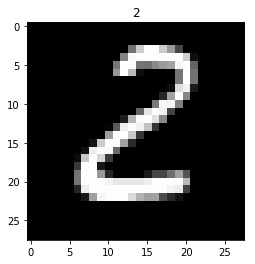

In [5]:
def get_sample(image_no):
    data = [(x,t) for x, t in zip(_x_train, _y_train) if t == image_no]
    x, y = data[0]
    return x,y
img_no = 2
img_data,img_label = get_sample(img_no)
plt.title(str(img_no))
plt.imshow(img_data,cmap="gray")

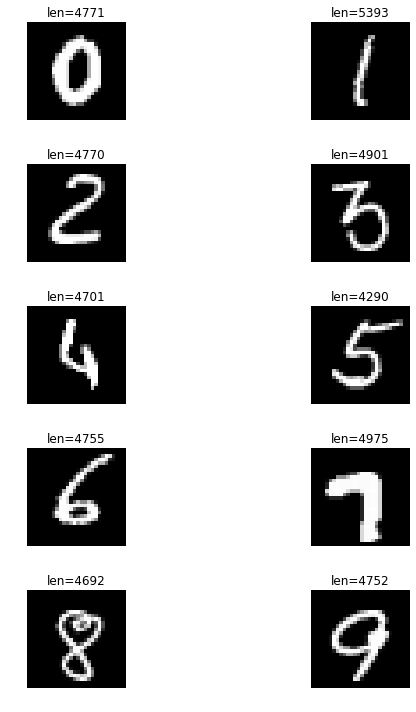

In [6]:
plt.figure(figsize=(10,10))

for i in range(10):
    data = [(x,t) for x, t in zip(_x_train, _y_train) if t == i]
    x, y = data[0]

    plt.subplot(5,2, i+1)
    # plt.title()
    plt.title("len={}".format(len(data)))
    
    plt.axis("off")
    plt.imshow(x, cmap='gray')

plt.tight_layout()
plt.show()

In [7]:
def preprocess(data, label=False):
    if label:
        # 教師データはto_categorical()でone-hot-encodingする。
        data = to_categorical(data)
    else:
        # 入力画像は、astype('float32')で型変換を行い、レンジを0-1にするために255で割る。
        # 0-255 -> 0-1
        data = data.astype('float32') / 255
        # Kerasの入力データの形式は(ミニバッチサイズ、横幅、縦幅、チャネル数)である必要があるので、reshape()を使って形式を変換する。
        # (sample, width, height) -> (sample, width, height, channel)
        data = data.reshape((-1, 28, 28, 1))

    return data

In [8]:
x_train = preprocess(_x_train)
x_val= preprocess(_x_val)
x_test = preprocess(_x_test)

y_train = preprocess(_y_train, label=True)
y_val = preprocess(_y_val, label=True)
y_test = preprocess(_y_test, label=True)

print(x_train.shape) # (48000, 28, 28, 1)
print(x_val.shape) # (12000, 28, 28, 1)
print(x_test.shape) # (10000, 28, 28, 1)
print(x_train.max()) # 1.0
print(x_val.max()) # 1.0
print(y_test.max()) # 1.0
print(y_train.shape) # (48000, 10)
print(y_val.shape) # (12000, 10) 
print(y_test.shape) # (10000, 10)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
1.0
1.0
1.0
(48000, 10)
(12000, 10)
(10000, 10)


In [9]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

In [10]:
datagen_train = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

datagen_valid = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=21,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=False,
    vertical_flip=False)

In [11]:
datagen_train.fit(x_train)
datagen_valid.fit(x_train)

In [12]:
train_generator = datagen_train.flow(x_train, y_train, batch_size=32)    
validation_generator = datagen_valid.flow(x_train, y_train, batch_size=32)    
test_generator = datagen_train.flow(x_train, y_train, batch_size=32)    

In [13]:
def get_model():
    
    inp = Input(shape=SHAPE+tuple([1]))

    x = Conv2D(32, (3, 3), activation='relu')(inp)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Conv2D(32, (3, 3), activation='relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x, training = True)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Conv2D(64, (3, 3), activation='relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x, training = True)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x, training = True)

    out = Dense(10, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [14]:

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)


In [15]:
SHAPE = (28, 28,)
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0     

In [16]:
train_num = 640
validation_num = 160
batch_size = 32
model.fit(train_generator, steps_per_epoch= train_num / batch_size,
          epochs=10, validation_data=validation_generator, validation_steps = validation_num / batch_size, 
          callbacks=[es], verbose = 1)

Epoch 1/10
20/20 [==============================] - 2s 78ms/step - loss: 2.2612 - accuracy: 0.1578 - val_loss: 2.1822 - val_accuracy: 0.1937
Epoch 2/10
20/20 [==============================] - 1s 60ms/step - loss: 1.9717 - accuracy: 0.3297 - val_loss: 1.9876 - val_accuracy: 0.3000
Epoch 3/10
20/20 [==============================] - 1s 58ms/step - loss: 1.6675 - accuracy: 0.4406 - val_loss: 1.8803 - val_accuracy: 0.4000
Epoch 4/10
20/20 [==============================] - 1s 59ms/step - loss: 1.5409 - accuracy: 0.4531 - val_loss: 1.8456 - val_accuracy: 0.3375
Epoch 5/10
20/20 [==============================] - 1s 59ms/step - loss: 1.3409 - accuracy: 0.5437 - val_loss: 1.5866 - val_accuracy: 0.4500
Epoch 6/10
20/20 [==============================] - 1s 61ms/step - loss: 1.1821 - accuracy: 0.5938 - val_loss: 1.3940 - val_accuracy: 0.5188
Epoch 7/10
20/20 [==============================] - 1s 59ms/step - loss: 1.0799 - accuracy: 0.6500 - val_loss: 1.3967 - val_accuracy: 0.5125
Epoch 8/10
20

In [17]:
### AUGMENT 100 TIMES EVERY SINGLE IMAGE ###
rep=100
validation_num = 100 #validation_generator.samples
image_valid, label_valid = [], []

for i, (batch, label) in enumerate(validation_generator):
    
    image_valid.append(batch)
    label_valid.append(label)
        
    if i == ((validation_num // batch_size)+1)*rep-1:
        break
        
image_valid = np.vstack(image_valid)
label_valid = np.argmax(np.vstack(label_valid), axis=1)

print(image_valid.shape, label_valid.shape)
#

(12800, 28, 28, 1) (12800,)


In [18]:
test_num = 100 #test_generator.samples

image_test, label_test = [], []
for i in range((test_num // batch_size)+1):
    x,y = test_generator.next()
    image_test.append(x)
    label_test.append(y)
        
image_test = np.vstack(image_test)
label_test = np.argmax(np.vstack(label_test), axis=1)

print(image_test.shape, label_test.shape)

(128, 28, 28, 1) (128,)


In [41]:
print("image_valid",image_valid.shape)
print("image_test",image_test.shape)

image_valid (12800, 28, 28, 1)
image_test (128, 28, 28, 1)


In [19]:
### COMPUTE PREDICTIONS ###

pred_prob_valid = model.predict(image_valid)
pred_valid = np.argmax(pred_prob_valid, axis=1)

pred_prob_test = model.predict(image_test)
pred_test = np.argmax(pred_prob_test, axis=1)

In [20]:
print(image_valid.shape)
print(pred_prob_valid.shape)
print(pred_valid.shape)
print(pred_prob_valid[0])
print(pred_valid[0])

(12800, 28, 28, 1)
(12800, 10)
(12800,)
[0.0009401  0.03721047 0.01754619 0.00368485 0.73305786 0.00905359
 0.15300539 0.00403131 0.01853509 0.02293512]
4


In [43]:
import pandas as pd
df_labes = pd.DataFrame()
df_labes["actual"] = [map_labels[label] for label in label_test]
df_labes["prediction"] = [map_labels[label] for label in pred_test]
df_labes.head(10)

,actual,prediction
0,8,9
1,2,2
2,3,3
3,8,8
4,3,3
5,3,3
6,0,0
7,4,4
8,5,3
9,9,9


In [21]:
print(classification_report([map_labels[label] for label in label_test], [map_labels[label] for label in pred_test]))

              precision    recall  f1-score   support

           0       0.91      0.62      0.74        16
           1       0.91      0.91      0.91        11
           2       0.57      0.89      0.70         9
           3       0.69      0.90      0.78        20
           4       1.00      0.67      0.80        18
           5       0.56      0.50      0.53        10
           6       0.62      0.83      0.71        12
           7       0.62      0.56      0.59         9
           8       0.86      0.46      0.60        13
           9       0.64      0.90      0.75        10

    accuracy                           0.73       128
   macro avg       0.74      0.72      0.71       128
weighted avg       0.76      0.73      0.72       128



In [22]:
### GET PROBABILITY DISTRIBUTIONS ON VALIDATION SET ###

diz_prob = {}
diz_prob_correct, diz_prob_mistake = {}, {}

#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] all labels
for i in np.unique(label_test):
    diz_prob_correct[i] = []
    diz_prob_mistake[i] = []
    diz_prob[i] = []

#for all validation,
#check if prediction is correct and add the probability to related list
for i,j,prob in zip(label_valid, pred_valid, pred_prob_valid):
    diz_prob[i].append(prob[j])
    
    if i == j:
        diz_prob_correct[j].append(prob[i])
    else:
        diz_prob_mistake[j].append(prob[j])

In [71]:
def draw_distributions(data,title):
    d_labels = [ a for a in data]
    d_data = [ len(data[a]) for a in data]
    plt.title(title)    
    plt.bar(d_labels,d_data)
    plt.show()
    

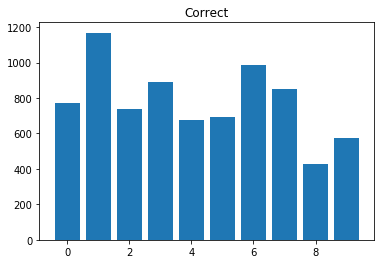

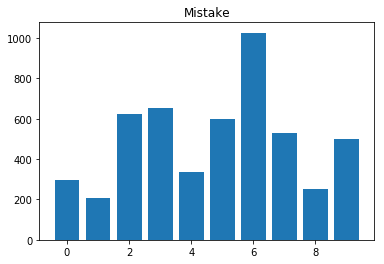

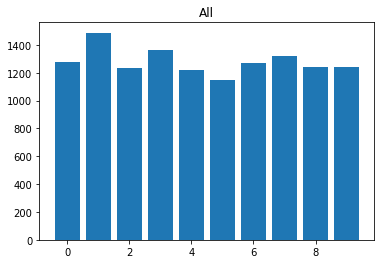

In [78]:
draw_distributions(diz_prob_correct,"Correct")
draw_distributions(diz_prob_mistake,"Mistake")
draw_distributions(diz_prob,"All")

In [46]:
len(diz_prob_mistake[0])
print("label_valid",label_valid.shape)
print("label_test",label_test.shape)
label_test.shape
np.unique(label_test)

label_valid (12800,)
label_test (128,)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

(array([ 15.,  99., 117., 148., 119., 108., 132., 103., 129., 304.]),
 array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 <a list of 10 Patch objects>)

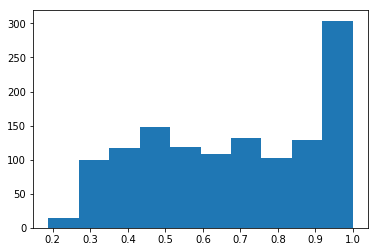

In [85]:
### ESTABLISH THRESHOLD FOR EACH CLASS ###

thresh_valid = {}
for i in range(10):
    thresh_valid[i] = np.quantile(diz_prob[i], 0.1)
 

print(thresh_valid)
#for i in range(10):
#    plt.title(str(i)+ " -> "+str(thresh_valid[i]))
#    plt.hist(diz_prob[i])
#    plt.show()

{0: 0.36293320953845976, 1: 0.3743027031421661, 2: 0.3646327018737793, 3: 0.3676191478967667, 4: 0.3359910845756531, 5: 0.3502654165029526, 6: 0.4113047897815705, 7: 0.3574727296829223, 8: 0.285548198223114, 9: 0.2947063148021698}


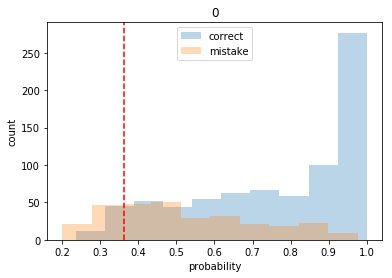

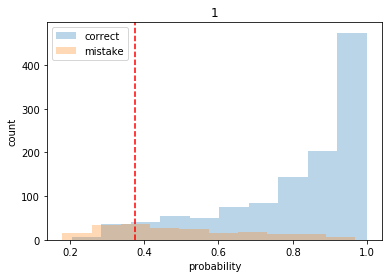

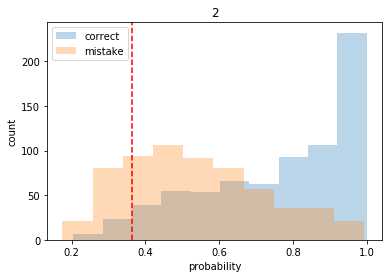

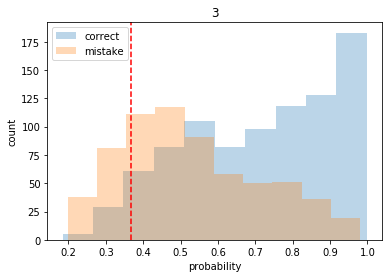

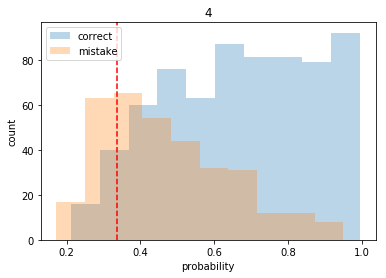

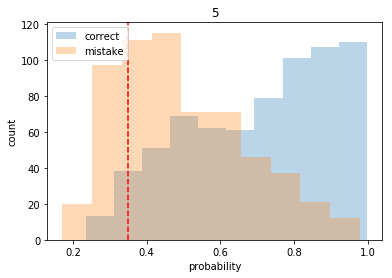

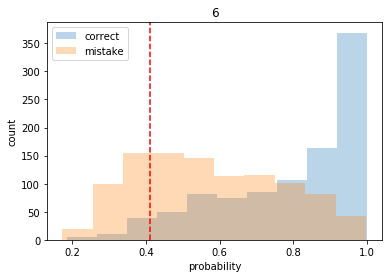

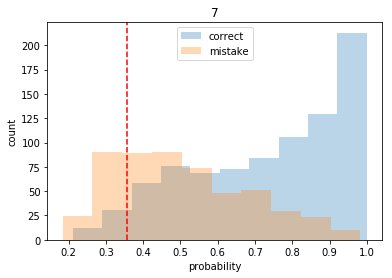

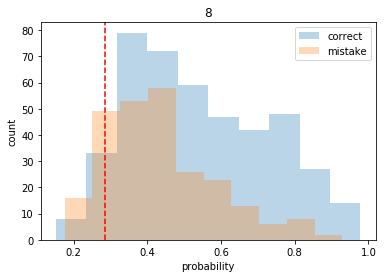

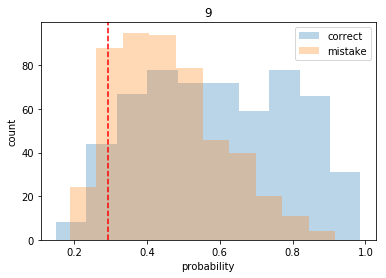

In [84]:
### PLOT PROBABILITY DISTRIBUTIONS ###

for i in range(10):
    
    plt.hist(diz_prob_correct[i], bins=10, alpha=0.3, label='correct')
    plt.hist(diz_prob_mistake[i], bins=10, alpha=0.3, label='mistake')
    plt.axvline(thresh_valid[i], color='red', linestyle='--')
    plt.legend(); plt.xlabel('probability'); plt.ylabel('count'); 
    plt.title(map_labels[i])
    plt.show()

np.set_printoptions(False)

In [87]:
### COMPUTE PREDICTIONS WITH THRESHOLD ###

count = 0
label_thresh, pred_thresh = [], []

for pred, pred_prob, label in zip(pred_test, pred_prob_test, label_test):

    if max(pred_prob) < thresh_valid[int(pred)]:
        print("-----------")
        print("pred_prob",pred_prob)
        print("max(pred_prob)",max(pred_prob))
        print("pred",pred)
        print("thresh_valid[int(pred)]",thresh_valid[int(pred)])
        count+=1
    else:
        pred_thresh.append(map_labels[pred])
        label_thresh.append(map_labels[label])
        
count # not classificable

-----------
pred_prob [9.e-04 8.e-04 3.e-01 2.e-01 1.e-05 2.e-01 4.e-03 5.e-05 3.e-01 8.e-05]
max(pred_prob) 0.33178213
pred 2
thresh_valid[int(pred)] 0.3646327018737793
-----------
pred_prob [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
max(pred_prob) 0.27215722
pred 8
thresh_valid[int(pred)] 0.285548198223114
-----------
pred_prob [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
max(pred_prob) 0.21635793
pred 7
thresh_valid[int(pred)] 0.3574727296829223
-----------
pred_prob [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
max(pred_prob) 0.32830617
pred 0
thresh_valid[int(pred)] 0.36293320953845976
-----------
pred_prob [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
max(pred_prob) 0.32463902
pred 2
thresh_valid[int(pred)] 0.3646327018737793
-----------
pred_prob [3.e-03 7.e-05 1.e-01 2.e-01 3.e-04 3.e-02 6.e-04 4.e-01 3.e-01 3.e-02]
max(pred_prob) 0.35645044
pred 7
thresh_valid[int(pred)] 0.3574727296829223


6

In [27]:
print(classification_report(label_thresh, pred_thresh))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       0.91      0.91      0.91        11
           2       0.58      0.88      0.70         8
           3       0.69      0.95      0.80        19
           4       1.00      0.71      0.83        17
           5       0.56      0.56      0.56         9
           6       0.62      0.91      0.74        11
           7       0.83      0.56      0.67         9
           8       0.83      0.42      0.56        12
           9       0.64      0.90      0.75        10

    accuracy                           0.75       122
   macro avg       0.77      0.74      0.73       122
weighted avg       0.79      0.75      0.74       122



(28, 28, 1)


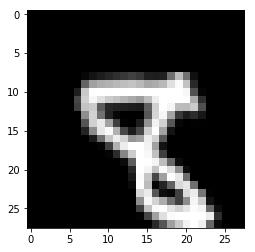

prediction for 0
predicted  9
[0.003850305452942848, 0.00027072164812125266, 0.017672939226031303, 0.05249970778822899, 0.01720413565635681, 0.2347274124622345, 0.013811673037707806, 0.038572534918785095, 0.1880817711353302, 0.43330875039100647]
prediction for 1
predicted  8
[0.0024577495642006397, 0.00011396350600989535, 0.022056499496102333, 0.015076780691742897, 0.007953716441988945, 0.10246948897838593, 0.007015596609562635, 0.016013316810131073, 0.5057640671730042, 0.3210788369178772]
prediction for 2
predicted  5
[0.003814847208559513, 0.00037297402741387486, 0.0652431845664978, 0.033929064869880676, 0.0419766791164875, 0.3482167720794678, 0.004842763766646385, 0.012923485599458218, 0.27538537979125977, 0.2132948935031891]
prediction for 3
predicted  8
[0.002239788183942437, 0.00012932145909871906, 0.2455345243215561, 0.0417458713054657, 0.014614381827414036, 0.11705499142408371, 0.038429584354162216, 0.0021234522573649883, 0.39398643374443054, 0.14414162933826447]
prediction for

In [104]:
timage = image_test[0]
print(timage.shape)
plt.imshow(timage.squeeze(),cmap="gray")
plt.show()
for i in range(10):
    preds = model.predict(timage.reshape(1,timage.shape[0],timage.shape[1],timage.shape[2]))
    print("prediction for",i)
    print("predicted ",np.argmax(preds))
    print( " ".join([str(p_sub) for p_sub in preds.tolist() ]))
    #for p in preds :
    #    print(p)
        #print( " ".join([p_sub for p_sub in p]))

In [105]:
image_test.shape

(128, 28, 28, 1)

In [29]:
### REACTIVATE DROPOUTS AND ITERATE PREDICTIONS ###

pred_bayes_dist = []
rep = 100

for i in tqdm(range(0,rep)):
    pred_bayes_dist.append(model.predict(image_test))
    
pred_bayes_dist = np.transpose(np.stack(pred_bayes_dist), (1,0,2))
pred_bayes_dist.shape

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.68it/s]


(128, 100, 10)

In [30]:
print(image_test.shape)
print(pred_bayes_dist.shape)
print(pred_bayes_dist[0][0])
print(pred_bayes_dist[0][0][1])

(128, 28, 28, 1)
(128, 100, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.00040161036


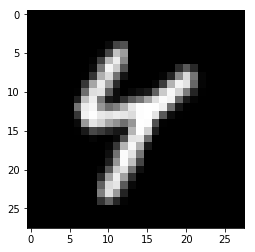

In [31]:

plt.imshow(image_test[110].squeeze()   ,cmap="gray"       )

related_preds (100, 10)


(array([81.,  0.,  0.,  0., 14.,  0.,  1.,  0.,  0.,  4.]),
 array([4., 4., 5., 6., 6., 6., 7., 8., 8., 8., 9.]),
 <a list of 10 Patch objects>)

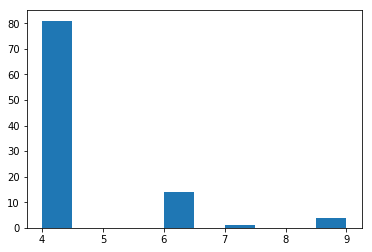

In [111]:
test_id = 14
related_preds = pred_bayes_dist[test_id]
print("related_preds",related_preds.shape)
related_labels = [ np.argmax(p) for p in related_preds]
plt.hist(related_labels)

pred_bayes_dist[test_id] (100, 10)
(28, 28, 1)


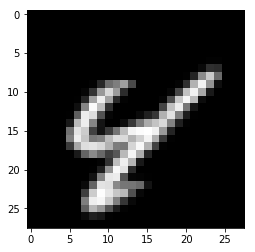

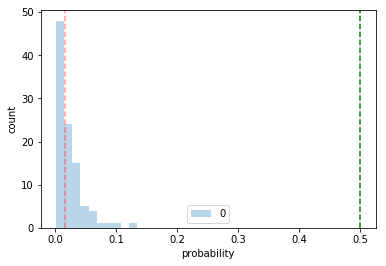

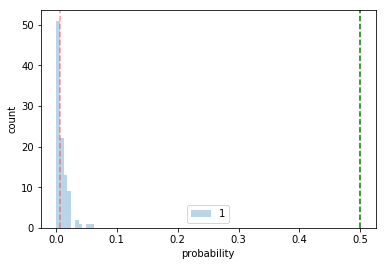

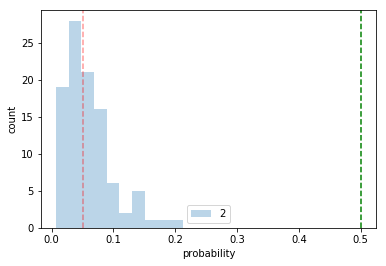

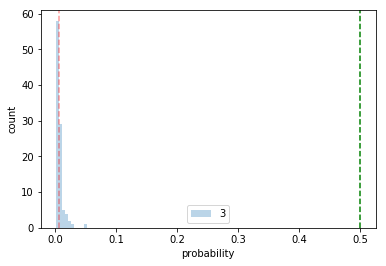

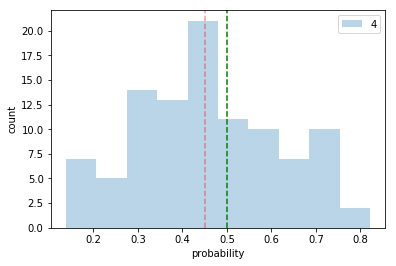

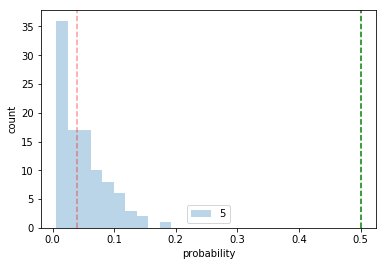

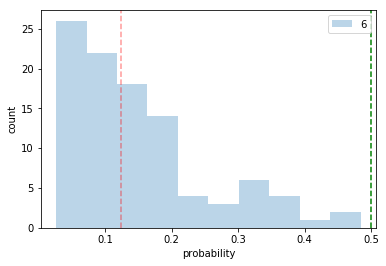

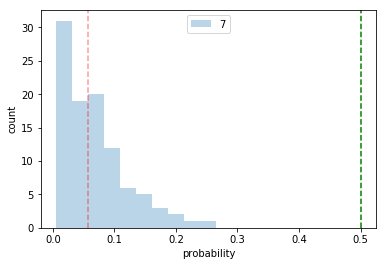

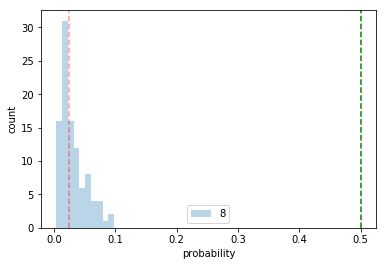

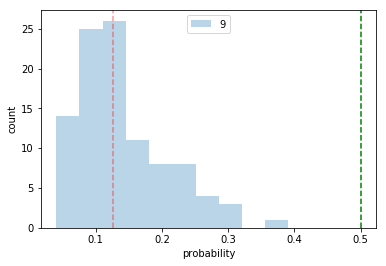

In [107]:
### VISUALIZE PROBABILITY DISTRIBUTIONS FOR A SPECIFIC TEST IMAGE ###


print("pred_bayes_dist[test_id]",pred_bayes_dist[test_id].shape)

timage = image_test[test_id]
print(timage.shape)
plt.imshow(timage.squeeze(),cmap="gray")
plt.show()

for i in range(10):
    
    plt.hist(pred_bayes_dist[test_id][:,i], alpha=0.3, label=map_labels[i])
    
    plt.axvline(np.quantile(pred_bayes_dist[test_id][:,i], 0.5), color='red', linestyle='--', alpha=0.4)
    plt.axvline(0.5, color='green', linestyle='--')
    plt.xlabel('probability'); plt.ylabel('count'); plt.legend()
    
    plt.show()
    
np.set_printoptions(False)
#below graps show, in cases that i made prediction as X(0,1...) what were the probabilities
#red line : for that prediction what was the 0.5 quantile

In [115]:
print("label_test",label_test.shape)
print("pred_bayes_dist",pred_bayes_dist.shape)

label_test (128,)
pred_bayes_dist (128, 100, 10)


In [119]:
### COMPUTE PREDICTIONS WITH THRESHOLD ###

count = 0
label_bayes, pred_bayes = [], []

for pred, label in zip(pred_bayes_dist, label_test):
    q_pred = np.quantile(pred, 0.5, axis=0)
    #print(pred)
    #print( q_pred[0] )
    #find the predictions which has more than 0.5 quantile calculated above for any of 100 predictions
    #not sure if this is a bit strict
    if len([q_p for q_p in q_pred if q_p>0.5])==0:
        print("---------------")
        print("pred",pred.shape)
        print("q_pred",q_pred)
        count+=1
    else:
        pred_bayes.append(map_labels[np.argmax(q_pred)])
        print("---------------")
        print("pred",pred.shape)
        print("q_pred",q_pred)
        print("argmax",np.argmax(q_pred))
        label_bayes.append(map_labels[label])

count # not classificable

---------------
pred (100, 10)
q_pred [1.e-03 3.e-04 2.e-02 2.e-02 3.e-02 8.e-02 6.e-03 4.e-02 1.e-01 6.e-01]
argmax 9
---------------
pred (100, 10)
q_pred [2.e-03 8.e-04 3.e-01 4.e-01 3.e-05 9.e-02 4.e-03 7.e-05 8.e-02 2.e-04]
---------------
pred (100, 10)
q_pred [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
argmax 5
---------------
pred (100, 10)
q_pred [6.e-03 1.e-03 4.e-03 6.e-03 3.e-04 6.e-02 4.e-03 4.e-03 9.e-01 2.e-02]
argmax 8
---------------
pred (100, 10)
q_pred [9.e-03 4.e-05 3.e-02 8.e-01 4.e-06 8.e-02 3.e-04 1.e-04 7.e-03 3.e-04]
argmax 3
---------------
pred (100, 10)
q_pred [2.e-04 2.e-06 7.e-04 9.e-01 1.e-05 1.e-01 9.e-06 1.e-04 1.e-03 1.e-03]
argmax 3
---------------
pred (100, 10)
q_pred [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
argmax 0
---------------
pred (100, 10)
q_pred [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
argmax 4
---------------
pred (100, 10)
q_pred [1.e-02 1.e-05 2.e-02 6.e-01 3.e-04 2.e-01 1.e-02 1.e-02 3.e-02 4.e-03]
argmax 3
---------------
pred (100, 10)
q_pred [0. 0. 0. 0. 0. 0. 0

34

In [34]:
print(classification_report(label_bayes, pred_bayes))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       1.00      1.00      1.00        10
           2       1.00      0.86      0.92         7
           3       0.86      0.95      0.90        19
           4       1.00      0.90      0.95        10
           5       0.67      0.80      0.73         5
           6       0.79      0.92      0.85        12
           7       1.00      1.00      1.00         5
           8       1.00      0.57      0.73         7
           9       0.86      0.86      0.86         7

    accuracy                           0.89        94
   macro avg       0.91      0.88      0.88        94
weighted avg       0.90      0.89      0.89        94



In [35]:
#!pip install cv

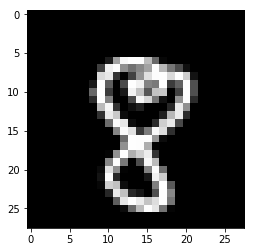

(28, 28, 3)


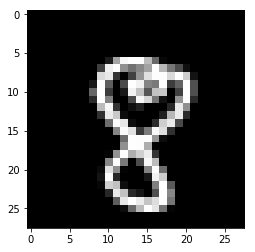

In [36]:
gray_img = x_train[0]
plt.imshow(x_train[0].reshape(28,28),cmap="gray")
plt.show()
import cv2
import cv

#color_img = cv2.cvtColor(gray_img, cv.CV_GRAY2RGB)
color_img = cv2.merge([gray_img,gray_img,gray_img])
plt.imshow(color_img )
print(color_img.shape)

In [38]:
def gen_samples(imgs,per_sample):
    generateds = []
    aug_iter = datagen.flow(imgs, batch_size=1)
    for i in range(per_sample):
        image = next(aug_iter)
        generateds.append(image)
    return generateds

gens = gen_samples(np.array([color_img]),3)
print(np.array(gens).shape)

(3, 1, 28, 28, 3)


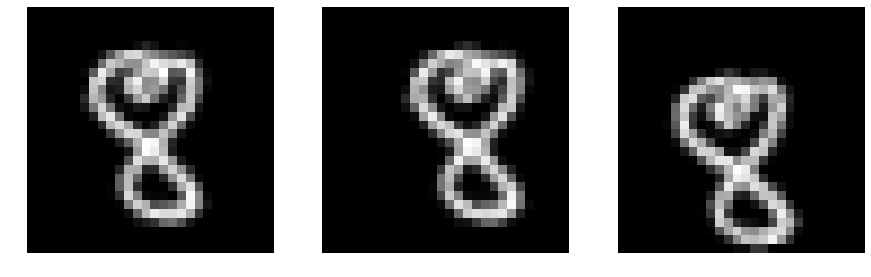

In [39]:
img_array = color_img
img = img_array.reshape(1,img_array.shape[0],img_array.shape[1],img_array.shape[2])

#print(set(img.flatten()))
aug_iter = datagen.flow(img, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	#image = next(aug_iter)[0].astype('uint8')
	image = next(aug_iter)
	#print(set(image.flatten()))
	# plot image
	#plt.imshow(image.reshape(28,28,3))
	#plt.show()
	ax[i].imshow(image.reshape(28,28,3))
	ax[i].axis('off')

In [40]:
image = next(aug_iter)
print(image.shape)
gray = cv2.cvtColor(image[0], cv2.COLOR_BGR2GRAY)
print(gray.shape)

(1, 28, 28, 3)
(28, 28)
